In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import string
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch

In [2]:
twitter_df=pd.read_csv("twitter.csv")
twitter_df["labels"] = twitter_df["class"].map({0: "Hate Speech", 1: "Offensive Language", 2: "No Hate and Offensive"})
twitter_df = twitter_df[["tweet", "labels"]]
twitter_df["tweet"][0]

"!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."

In [3]:
twitter_df["labels"].unique()

array(['No Hate and Offensive', 'Offensive Language', 'Hate Speech'],
      dtype=object)

# Statistical features

# Number of unique words , Average sentence length and noun, adjective and verb counts

In [4]:
tweets=twitter_df["tweet"]
all_tweets_text = ' '.join(tweets)
words = all_tweets_text.split()
unique_words = set(words)
num_unique_words = len(unique_words)
print("Number of unique words:", num_unique_words)

Number of unique words: 59006


In [5]:
import nltk
all_tweets_text = ' '.join(tweets)
sentences = nltk.sent_tokenize(all_tweets_text)
total_words = sum(len(nltk.word_tokenize(sentence)) for sentence in sentences)
average_sentence_length = total_words / len(sentences)
print("Average sentence length:", average_sentence_length)

Average sentence length: 33.43659971596673


In [6]:
from textblob import TextBlob
from collections import Counter
all_tweets_text = ' '.join(tweets)
blob = TextBlob(all_tweets_text)
noun_counts = Counter()
verb_counts = Counter()
adjective_counts = Counter()

for word, pos in blob.tags:
    if pos == 'NN':  
        noun_counts[word] += 1
    elif pos == 'VB':  
        verb_counts[word] += 1
    elif pos == 'JJ':  
        adjective_counts[word] += 1


print("Nouns:", noun_counts)
print("Verbs:", verb_counts)
print("Adjectives:", adjective_counts)


KeyboardInterrupt



In [ ]:
noun_df = pd.DataFrame(noun_counts.items(), columns=['Noun', 'Count'])
verb_df = pd.DataFrame(verb_counts.items(), columns=['Verb', 'Count'])
adjective_df = pd.DataFrame(adjective_counts.items(), columns=['Adjective', 'Count'])

In [ ]:
noun_df

In [ ]:
verb_df

In [ ]:
adjective_df

# bert model 

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name).to(device)
def tokenize_text(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=64).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings

In [47]:
twitter_df['embeddings'] = twitter_df['tweet'].apply(tokenize_text)

In [50]:
with open('embeddings.pkl', 'wb') as file:
    pickle.dump(twitter_df['embeddings'], file)

In [7]:
import pickle
with open('embeddings.pkl', 'rb') as file:
    loaded_embeddings = pickle.load(file)

In [8]:
twitter_df['embeddings']=loaded_embeddings

In [9]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(twitter_df["labels"])
twitter_df["labels_encoded"] = encoded_labels

In [10]:
twitter_df
columns_to_show = ["embeddings", "labels_encoded"]
twitter_df[columns_to_show]

,embeddings,labels_encoded
0,"[[tensor(0.2095), tensor(0.2316), tensor(0.492...",1
1,"[[tensor(-0.0849), tensor(0.0519), tensor(0.68...",2
2,"[[tensor(0.3709), tensor(0.3706), tensor(0.621...",2
3,"[[tensor(0.4781), tensor(0.0631), tensor(0.642...",2
4,"[[tensor(0.3976), tensor(0.1870), tensor(0.605...",2
...,...,...
24778,"[[tensor(0.4247), tensor(0.2765), tensor(0.517...",2
24779,"[[tensor(0.2655), tensor(-0.0583), tensor(-0.1...",1
24780,"[[tensor(0.0799), tensor(0.1272), tensor(0.783...",2
24781,"[[tensor(0.4994), tensor(0.4589), tensor(0.205...",2


In [12]:
X = twitter_df['embeddings'] 
empty=[]
for i in X:
    empty.append(i)
    
X=torch.concat(empty)
y = twitter_df['labels_encoded'] 
y=torch.tensor([i for i in y])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=43)

In [13]:
import tensorflow as tf
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64) 
y_test = torch.tensor(y_test, dtype=torch.int64)

C:\Users\HP\AppData\Local\Temp\ipykernel_1972\3792690778.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
C:\Users\HP\AppData\Local\Temp\ipykernel_1972\3792690778.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
C:\Users\HP\AppData\Local\Temp\ipykernel_1972\3792690778.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.int64)
C:\Users\HP\AppData\Local\Temp\ipykernel_1972\3792690778.py:5:

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([22304, 768])
torch.Size([2479, 768])
torch.Size([22304])
torch.Size([2479])


In [15]:
import torch
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(RNNModel, self).__init__()
        self.rnn1 = nn.RNN(input_size, hidden_size1, batch_first=True)
        self.rnn2 = nn.RNN(hidden_size1, hidden_size2, batch_first=True)
        self.fc = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        out, hidden1 = self.rnn1(x)
        out, hidden2 = self.rnn2(out)
        
        out = self.fc(out)
        return out

input_size = 768
output_size = 3
model = RNNModel(input_size, 64, 32, output_size)
print(model)


RNNModel(
  (rnn1): RNN(768, 64, batch_first=True)
  (rnn2): RNN(64, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)


In [16]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train, y_train)
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
import torch.optim as optim
import torch.nn as nn
import time

num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
train_accuracies = []
test_accuracies = []

epoch_execution_times = []  

for epoch in range(num_epochs):
    start_time = time.time()  

    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()  
        output = model(batch_x) 
        loss = criterion(output, batch_y)  
        loss.backward()  
        optimizer.step()  

        total_loss += loss.item()

        _, predicted_train = torch.max(output.data, 1)
        total_train += batch_y.size(0)
        correct_train += (predicted_train == batch_y).sum().item()

    average_loss = total_loss / len(train_loader)
    training_accuracy = correct_train / total_train
    
    model.eval()  
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            output = model(batch_x)
            _, predicted_test = torch.max(output.data, 1)
            total_test += batch_y.size(0)
            correct_test += (predicted_test == batch_y).sum().item()

    testing_accuracy = correct_test / total_test

    train_accuracies.append(training_accuracy)
    test_accuracies.append(testing_accuracy)

    end_time = time.time()  
    epoch_execution_time = end_time - start_time
    epoch_execution_times.append(epoch_execution_time)  

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Training Accuracy: {training_accuracy * 100:.2f}%, Testing Accuracy: {testing_accuracy * 100:.2f}%, Epoch Time: {epoch_execution_time:.4f} seconds')

print('Training complete.')

Epoch [1/10], Loss: 0.8760, Training Accuracy: 58.51%, Testing Accuracy: 77.49%, Epoch Time: 13.7804 seconds
Epoch [2/10], Loss: 0.6779, Training Accuracy: 77.43%, Testing Accuracy: 77.49%, Epoch Time: 11.5892 seconds
Epoch [3/10], Loss: 0.6476, Training Accuracy: 77.43%, Testing Accuracy: 77.49%, Epoch Time: 11.7149 seconds
Epoch [4/10], Loss: 0.6312, Training Accuracy: 77.43%, Testing Accuracy: 77.49%, Epoch Time: 11.5460 seconds
Epoch [5/10], Loss: 0.6129, Training Accuracy: 77.43%, Testing Accuracy: 77.49%, Epoch Time: 11.6717 seconds
Epoch [6/10], Loss: 0.5928, Training Accuracy: 77.43%, Testing Accuracy: 77.49%, Epoch Time: 12.2839 seconds
Epoch [7/10], Loss: 0.5741, Training Accuracy: 77.59%, Testing Accuracy: 77.73%, Epoch Time: 12.6111 seconds
Epoch [8/10], Loss: 0.5550, Training Accuracy: 78.37%, Testing Accuracy: 78.58%, Epoch Time: 12.6304 seconds
Epoch [9/10], Loss: 0.5374, Training Accuracy: 79.94%, Testing Accuracy: 80.19%, Epoch Time: 12.1881 seconds
Epoch [10/10], Loss

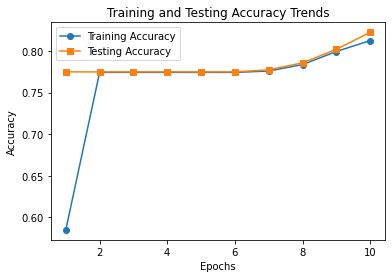

In [18]:
import matplotlib.pyplot as plt
epochs_list = range(1, num_epochs + 1)
plt.plot(epochs_list, train_accuracies, marker='o', linestyle='-', label='Training Accuracy')
plt.plot(epochs_list, test_accuracies, marker='s', linestyle='-', label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy Trends')
plt.legend()
plt.show()

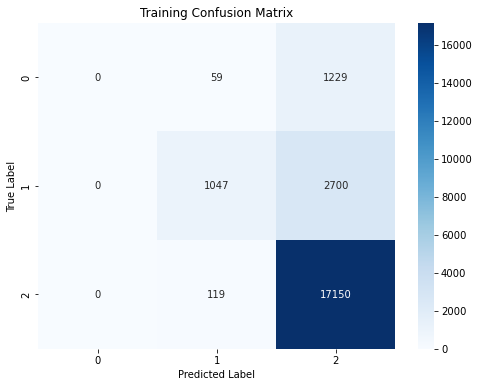

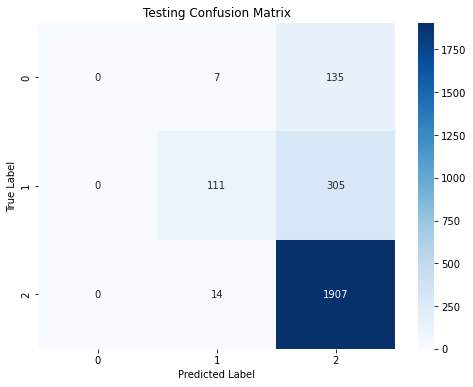

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
def plot_confusion_matrix(matrix, classes, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
model.eval()
all_predicted_train = []
all_labels_train = []

with torch.no_grad():
    for batch_x, batch_y in train_loader:
        output = model(batch_x)
        _, predicted_train = torch.max(output.data, 1)
        all_predicted_train.extend(predicted_train.cpu().numpy())
        all_labels_train.extend(batch_y.cpu().numpy())

classes = range(output_size)
conf_matrix_train = confusion_matrix(all_labels_train, all_predicted_train)
plot_confusion_matrix(conf_matrix_train, classes, title='Training Confusion Matrix')
model.eval()
all_predicted_test = []
all_labels_test = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        output = model(batch_x)
        _, predicted_test = torch.max(output.data, 1)
        all_predicted_test.extend(predicted_test.cpu().numpy())
        all_labels_test.extend(batch_y.cpu().numpy())

conf_matrix_test = confusion_matrix(all_labels_test, all_predicted_test)
plot_confusion_matrix(conf_matrix_test, classes, title='Testing Confusion Matrix')

# USING TFID VECTORIZER 

In [58]:
twitter_df["tweet"]
from sklearn.feature_extraction.text import TfidfVectorizer
tweets = twitter_df["tweet"]
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(tweets)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
y = twitter_df['labels_encoded']
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.1, random_state=43)

In [59]:
X_train_tensor = torch.sparse.FloatTensor(torch.LongTensor(X_train.nonzero()), torch.FloatTensor(X_train.data), X_train.shape)
X_test_tensor = torch.sparse.FloatTensor(torch.LongTensor(X_test.nonzero()), torch.FloatTensor(X_test.data), X_test.shape)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [60]:
X_train_tensor.shape

torch.Size([22304, 35573])

In [61]:
batch_size = 64
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [62]:
model = RNNModel(768, 64, 32, 3)


In [63]:
import torch.optim as optim
import torch.nn as nn
import time

num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

tfidf_train_accuracy_list = []
tfidf_test_accuracy_list = []
tfidf_execution_times = []

for epoch in range(num_epochs):
    start_time = time.time()

    model.train() 
    total_loss = 0
    correct_train = 0
    total_train = 0

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()  
        output = model(batch_x) 
        loss = criterion(output, batch_y)  
        loss.backward()  
        optimizer.step()  

        total_loss += loss.item()

        _, predicted_train = torch.max(output.data, 1)
        total_train += batch_y.size(0)
        correct_train += (predicted_train == batch_y).sum().item()

    average_loss = total_loss / len(train_loader)
    training_accuracy = correct_train / total_train
    
    model.eval()  
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            output = model(batch_x)
            _, predicted_test = torch.max(output.data, 1)
            total_test += batch_y.size(0)
            correct_test += (predicted_test == batch_y).sum().item()

    testing_accuracy = correct_test / total_test

    tfidf_train_accuracy_list.append(training_accuracy)
    tfidf_test_accuracy_list.append(testing_accuracy)

    end_time = time.time()
    epoch_execution_time = end_time - start_time
    tfidf_execution_times.append(epoch_execution_time)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Training Accuracy: {training_accuracy * 100:.2f}%, Testing Accuracy: {testing_accuracy * 100:.2f}%, Epoch Time: {epoch_execution_time:.4f} seconds')

print('Training complete.')

Epoch [1/10], Loss: 0.4486, Training Accuracy: 84.06%, Testing Accuracy: 87.41%, Epoch Time: 5.1562 seconds
Epoch [2/10], Loss: 0.3641, Training Accuracy: 86.83%, Testing Accuracy: 87.98%, Epoch Time: 6.2828 seconds
Epoch [3/10], Loss: 0.3450, Training Accuracy: 87.27%, Testing Accuracy: 87.74%, Epoch Time: 7.5947 seconds
Epoch [4/10], Loss: 0.3335, Training Accuracy: 87.70%, Testing Accuracy: 87.25%, Epoch Time: 7.2654 seconds
Epoch [5/10], Loss: 0.3260, Training Accuracy: 87.85%, Testing Accuracy: 88.66%, Epoch Time: 7.6377 seconds
Epoch [6/10], Loss: 0.3195, Training Accuracy: 88.08%, Testing Accuracy: 86.85%, Epoch Time: 7.6879 seconds
Epoch [7/10], Loss: 0.3111, Training Accuracy: 88.46%, Testing Accuracy: 88.75%, Epoch Time: 7.3139 seconds
Epoch [8/10], Loss: 0.3037, Training Accuracy: 88.68%, Testing Accuracy: 88.06%, Epoch Time: 7.8329 seconds
Epoch [9/10], Loss: 0.2976, Training Accuracy: 88.77%, Testing Accuracy: 87.94%, Epoch Time: 6.9598 seconds
Epoch [10/10], Loss: 0.2905,

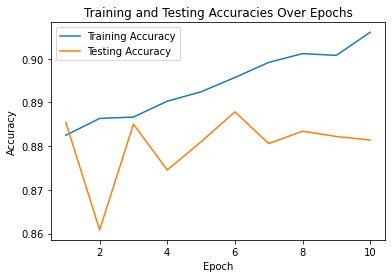

In [64]:
import matplotlib.pyplot as plt
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies_list, label='Training Accuracy')
plt.plot(epochs, test_accuracies_list, label='Testing Accuracy')
plt.title('Training and Testing Accuracies Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [65]:
from sklearn.metrics import confusion_matrix, classification_report
model.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        output = model(batch_x)
        _, predicted = torch.max(output, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_predictions)
class_report = classification_report(all_labels, all_predictions)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[  20    5  117]
 [   2  286  128]
 [  11   38 1872]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.14      0.23       142
           1       0.87      0.69      0.77       416
           2       0.88      0.97      0.93      1921

    accuracy                           0.88      2479
   macro avg       0.79      0.60      0.64      2479
weighted avg       0.87      0.88      0.86      2479



# using count vectorizer

In [66]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import torch

tweets = twitter_df["tweet"]
y = twitter_df['labels_encoded']
vectorizer = CountVectorizer(stop_words='english')
X_bow = vectorizer.fit_transform(tweets)
X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.1, random_state=43)
X_train_tensor = torch.sparse.FloatTensor(torch.LongTensor(X_train.nonzero()), torch.FloatTensor(X_train.data), X_train.shape)
X_test_tensor = torch.sparse.FloatTensor(torch.LongTensor(X_test.nonzero()), torch.FloatTensor(X_test.data), X_test.shape)
train_dataset = TensorDataset(X_train_tensor, torch.tensor(y_train.values, dtype=torch.float32))
test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test.values, dtype=torch.float32))
batch_size = 64
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [67]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(RNNModel, self).__init__()
        self.rnn1 = nn.RNN(input_size, hidden_size1, batch_first=True)
        self.rnn2 = nn.RNN(hidden_size1, hidden_size2, batch_first=True)
        self.fc = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        out, hidden1 = self.rnn1(x)
        out, hidden2 = self.rnn2(out)
        out = self.fc(out)
        return out

In [69]:
import torch.optim as optim
import torch.nn as nn
import time

model = RNNModel(35573, 64, 32, 3)
count_time = []  
count_train_accuracy = []  
count_test_accuracy = [] 

num_epochs = 10
for epoch in range(num_epochs):
    start_time = time.time()  

    model.train() 
    total_train_correct = 0
    total_train_samples = 0

    for batch_x, batch_y in trainloader:
        optimizer.zero_grad()  
        
        dense_x = batch_x.to_dense()

        output = model(dense_x)  

       
        loss = criterion(output.squeeze(), batch_y.long())
        loss.backward()
        optimizer.step()

        # Update training accuracy
        _, predicted = torch.max(output, 1)
        total_train_correct += (predicted == batch_y).sum().item()
        total_train_samples += batch_y.size(0)

    train_accuracy = total_train_correct / total_train_samples
    count_train_accuracy.append(train_accuracy)

    model.eval() 
    total_test_correct = 0
    total_test_samples = 0

    with torch.no_grad():  
        for batch_x, batch_y in testloader:
            dense_x_test = batch_x.to_dense()

            output = model(dense_x_test)  

            # Update testing accuracy
            _, predicted_test = torch.max(output.data, 1)
            total_test_correct += (predicted_test == batch_y).sum().item()
            total_test_samples += batch_y.size(0)

    test_accuracy = total_test_correct / total_test_samples
    count_test_accuracy.append(test_accuracy)

    end_time = time.time()  
    epoch_execution_time = end_time - start_time
    count_time.append(epoch_execution_time) 

    print(f'Epoch [{epoch + 1}/{num_epochs}], 'f'Training Accuracy: {train_accuracy:.4f}, 'f'Testing Accuracy: {test_accuracy:.4f}, '
          f'Epoch Time: {epoch_execution_time:.4f} seconds')
print('Training complete!')

Epoch [1/10], Training Accuracy: 0.3301, Testing Accuracy: 0.3276, Epoch Time: 23.5660 seconds
Epoch [2/10], Training Accuracy: 0.3268, Testing Accuracy: 0.3276, Epoch Time: 21.9462 seconds
Epoch [3/10], Training Accuracy: 0.3319, Testing Accuracy: 0.3276, Epoch Time: 27.8437 seconds
Epoch [4/10], Training Accuracy: 0.3262, Testing Accuracy: 0.3276, Epoch Time: 27.3863 seconds
Epoch [5/10], Training Accuracy: 0.3279, Testing Accuracy: 0.3276, Epoch Time: 23.2023 seconds
Epoch [6/10], Training Accuracy: 0.3248, Testing Accuracy: 0.3276, Epoch Time: 28.3924 seconds
Epoch [7/10], Training Accuracy: 0.3289, Testing Accuracy: 0.3276, Epoch Time: 24.7476 seconds
Epoch [8/10], Training Accuracy: 0.3273, Testing Accuracy: 0.3276, Epoch Time: 24.1367 seconds
Epoch [9/10], Training Accuracy: 0.3268, Testing Accuracy: 0.3276, Epoch Time: 27.5040 seconds
Epoch [10/10], Training Accuracy: 0.3286, Testing Accuracy: 0.3276, Epoch Time: 26.0225 seconds
Training complete!


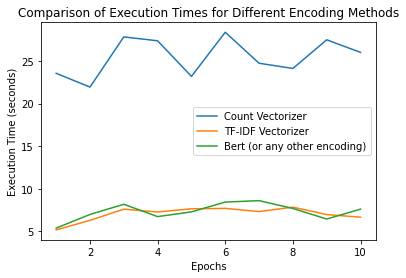

In [73]:
epochs = range(1, num_epochs + 1)
plt.plot(epochs, count_time, label='Count Vectorizer')
plt.plot(epochs, tfidf_execution_times, label='TF-IDF Vectorizer')
plt.plot(epochs, epoch_execution_times, label='Bert (or any other encoding)')
plt.xlabel('Epochs')
plt.ylabel('Execution Time (seconds)')
plt.title('Comparison of Execution Times for Different Encoding Methods')
plt.legend()
plt.show()

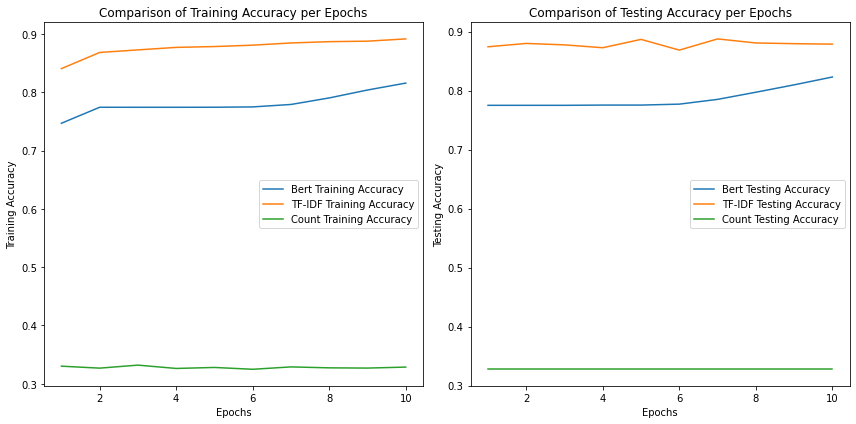

In [75]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Bert Training Accuracy')
plt.plot(epochs, tfidf_train_accuracy_list, label='TF-IDF Training Accuracy')
plt.plot(epochs, count_train_accuracy, label='Count Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Comparison of Training Accuracy per Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label='Bert Testing Accuracy')
plt.plot(epochs, tfidf_test_accuracy_list, label='TF-IDF Testing Accuracy')
plt.plot(epochs, count_test_accuracy, label='Count Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Testing Accuracy')
plt.title('Comparison of Testing Accuracy per Epochs')
plt.legend()
plt.tight_layout()
plt.show()

In [76]:
twitter_df
columns_to_show = ["embeddings", "labels_encoded"]
twitter_df[columns_to_show]

,embeddings,labels_encoded
0,"[[tensor(0.2095), tensor(0.2316), tensor(0.492...",1
1,"[[tensor(-0.0849), tensor(0.0519), tensor(0.68...",2
2,"[[tensor(0.3709), tensor(0.3706), tensor(0.621...",2
3,"[[tensor(0.4781), tensor(0.0631), tensor(0.642...",2
4,"[[tensor(0.3976), tensor(0.1870), tensor(0.605...",2
...,...,...
24778,"[[tensor(0.4247), tensor(0.2765), tensor(0.517...",2
24779,"[[tensor(0.2655), tensor(-0.0583), tensor(-0.1...",1
24780,"[[tensor(0.0799), tensor(0.1272), tensor(0.783...",2
24781,"[[tensor(0.4994), tensor(0.4589), tensor(0.205...",2


In [77]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
text = "!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."
tokens = tokenizer.encode(text, add_special_tokens=True)
import torch
tokens_tensor = torch.tensor([tokens])

with torch.no_grad():
    outputs = model(tokens_tensor)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [78]:
from transformers import BertTokenizer, BertModel
import torch

def predict_text_class(text):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    tokens = tokenizer.encode(text, add_special_tokens=True)
    tokens_tensor = torch.tensor([tokens])

    with torch.no_grad():
        outputs = model(tokens_tensor)

    classification_layer = torch.nn.Linear(model.config.hidden_size, 3)
    logits = classification_layer(outputs.last_hidden_state[:, 0, :])
    probs = torch.nn.functional.softmax(logits, dim=-1)
    _, predicted_class = torch.max(probs, 1)

    class_labels = ['No Hate and Offensive', 'Offensive Language', 'Hate Speech']
    return f"Predicted class: {class_labels[predicted_class.item()]}"

text = '!!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just blows me..claim you so faithful and down for somebody but still fucking with hoes! &#128514;&#128514;&#128514;"'
prediction = predict_text_class(text)
print(prediction)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Predicted class: Offensive Language


In [105]:
twitter_df["tweet"][6]

'!!!!!!"@__BrighterDays: I can not just sit up and HATE on another bitch .. I got too much shit going on!"'

In [ ]:
from flask import Flask, render_template, request
from transformers import BertTokenizer, BertModel
import torch
app = Flask(__name__)

def predict_text_class(text):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    tokens = tokenizer.encode(text, add_special_tokens=True)
    tokens_tensor = torch.tensor([tokens])

    with torch.no_grad():
        outputs = model(tokens_tensor)

    classification_layer = torch.nn.Linear(model.config.hidden_size, 3)
    logits = classification_layer(outputs.last_hidden_state[:, 0, :])
    probs = torch.nn.functional.softmax(logits, dim=-1)
    _, predicted_class = torch.max(probs, 1)

    class_labels = ['No Hate and Offensive', 'Offensive Language', 'Hate Speech']
    return class_labels[predicted_class.item()]

@app.route('/', methods=['GET', 'POST'])
def index():
    prediction = None
    if request.method == 'POST':
        text = request.form['text']
        prediction = predict_text_class(text)

    response_html = f'''
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Twitter Classification App!</title>
        <!-- Add Bootstrap CSS link -->
        <link href="https://stackpath.bootstrapcdn.com/bootstrap/4.3.1/css/bootstrap.min.css" rel="stylesheet">
        <!-- Add custom styles -->
        <style>
            body {{
                background: linear-gradient(45deg, #3498db, #e74c3c); /* Gradient background */
                color: #fff; /* White text */
            }}
            .container {{
                margin-top: 50px;
            }}
            .logo-img {{
                width: 150px; /* Adjust the width as needed */
                height: auto;
            }}
        </style>
    </head>
    <body>
        <div class="container">
            <div class="text-center">
                
            </div>
            <h1 class="display-4 text-center"><strong>Text Classification App</strong></h1>
            <form method="post">
                <div class="form-group">
                    <label for="text" class="text-white">Enter Text:</label>
                    <textarea class="form-control" name="text" rows="8" required></textarea>
                </div>
                <button type="submit" class="btn btn-primary">Predict</button>
            </form>
            {f"<p class='mt-3 text-white'><strong>Prediction:</strong> {prediction}</p>" if prediction else ""}
        </div>
        <!-- Add Bootstrap JS and Popper.js scripts -->
        <script src="https://code.jquery.com/jquery-3.3.1.slim.min.js"></script>
        <script src="https://cdnjs.cloudflare.com/ajax/libs/popper.js/1.14.7/umd/popper.min.js"></script>
        <script src="https://stackpath.bootstrapcdn.com/bootstrap/4.3.1/js/bootstrap.min.js"></script>
    </body>
    </html>
    '''

    if prediction:
        prediction = None

    return response_html

if __name__ == '__main__':
    app.run(debug=True, use_reloader=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [07/Dec/2023 11:29:05] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2023 11:29:05] "GET /favicon.ico HTTP/1.1" 404 -
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a Be